# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

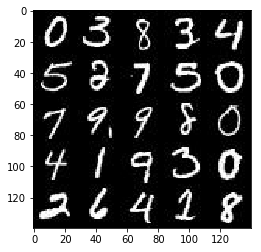

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

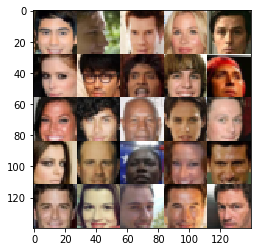

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.3.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    input_real = tf.placeholder(tf.float32, [None, image_width, image_height, image_channels], name='input_real')
    input_z = tf.placeholder(tf.float32, [None, z_dim], name='input_z')
    lr = tf.placeholder(tf.float32, name='lr')

    return input_real, input_z, lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
['File "/home/bipe26194/miniconda3/envs/tensorflow/lib/python3.6/runpy.py", line 193, in _run_module_as_main\n    "__main__", mod_spec)', 'File "/home/bipe26194/miniconda3/envs/tensorflow/lib/python3.6/runpy.py", line 85, in _run_code\n    exec(code, run_globals)', 'File "/home/bipe26194/miniconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>\n    app.launch_new_instance()', 'File "/home/bipe26194/miniconda3/envs/tensorflow/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance\n    app.start()', 'File "/home/bipe26194/miniconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 477, in start\n    ioloop

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [25]:
import numpy as np

def leaky_relu(x, alpha):
    """
    A Leaky Rectified Linear Unit
    :param x: Input tensor
    :param alpha: Slope of the leaky output
    :return: Output tensor
    """
    return tf.maximum(alpha * x, x)

def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    with tf.variable_scope('discriminator', reuse=reuse):
        k_init = tf.contrib.layers.xavier_initializer(uniform=False)
        alpha = 0.2
        
        # Convolution layer 0: 28x28x3 -> 14x14x64
        layer0 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same', kernel_initializer=k_init)
        layer0 = leaky_relu(layer0, alpha)
        
        # Convolution layer 1: 14x14x64 -> 7x7x128
        layer1 = tf.layers.conv2d(layer0, 128, 5, strides=2, padding='same', kernel_initializer=k_init)
        layer1 = tf.layers.batch_normalization(layer1, training=True)
        layer1 = leaky_relu(layer1, alpha)
        
        # Convolution layer 2: 7x7x128 -> 4x4x256
        layer2 = tf.layers.conv2d(layer1, 256, 5, strides=2, padding='same', kernel_initializer=k_init)
        layer2 = tf.layers.batch_normalization(layer2, training=True)
        layer2 = leaky_relu(layer2, alpha)
        
        # Fully-connected layer: 4x4x256 -> 1
        logits = tf.reshape(layer2, [-1, 4*4*256])
        logits = tf.layers.dense(logits, 1, activation=None)
        
        output = tf.sigmoid(logits)

        return output, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [26]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    with tf.variable_scope('generator', reuse=not is_train):
        k_init = tf.contrib.layers.xavier_initializer(uniform=False)
        alpha = 0.2
        
        # Fully-connected layer: z -> 4x4x512
        layer0 = tf.layers.dense(z, 4*4*512, activation=None)
        layer0 = tf.reshape(layer0, [-1, 4, 4, 512])
        layer0 = tf.layers.batch_normalization(layer0, training=is_train)
        layer0 = leaky_relu(layer0, alpha)
        
        # Convolution layer 1: 4x4x512 -> 7x7x256
        layer1 = tf.layers.conv2d_transpose(layer0, 256, 4, strides=1, padding='valid', kernel_initializer=k_init)
        layer1 = tf.layers.batch_normalization(layer1, training=is_train)
        layer1 = leaky_relu(layer1, alpha)
        
        # Convolution layer 2: 7x7x256 -> 14x14x128
        layer2 = tf.layers.conv2d_transpose(layer1, 128, 5, strides=2, padding='same', kernel_initializer=k_init)
        layer2 = tf.layers.batch_normalization(layer2, training=is_train)
        layer2 = leaky_relu(layer2, alpha)
        
        # Convolution layer 3: 14x14x128 -> 28x28x64
        layer3 = tf.layers.conv2d_transpose(layer2, 64, 5, strides=2, padding='same', kernel_initializer=k_init)
        layer3 = tf.layers.batch_normalization(layer3, training=is_train)
        layer3 = leaky_relu(layer3, alpha)
        
        # Output image: 28x28x64 -> 28x28x3
        logits = tf.layers.conv2d_transpose(layer3, out_channel_dim, 5, strides=1, padding='same', kernel_initializer=k_init)
        
        output = tf.tanh(logits)
        
        return output

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [27]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # Output
    g_output = generator(input_z, out_channel_dim, is_train=True)
    d_output_real, d_logits_real = discriminator(input_real, reuse=False)
    d_output_fake, d_logits_fake = discriminator(g_output, reuse=True)
    
    # Discriminator loss
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
        logits=d_logits_real, 
        labels=tf.ones_like(d_output_real) * 0.9))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
        logits=d_logits_fake, 
        labels=tf.zeros_like(d_output_fake)))
    d_loss = d_loss_real + d_loss_fake
    
    # Generator loss
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
        logits=d_logits_fake, 
        labels=tf.ones_like(d_output_fake)))
    
    return d_loss, g_loss

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [28]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [29]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [32]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    out_channel_dim = data_shape[3]
    
    # Tensors and operations
    input_real, input_z, lr = model_inputs(*data_shape[1:], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, out_channel_dim)
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    steps = 0
    show_every = 200
    print_every = 40
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                
                # Real image input, scaled from [-0.5, 0.5] to [-1, 1]
                batch_images = batch_images * 2
                
                # z data input
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Update weights and biases
                sess.run(d_opt, feed_dict={input_z: batch_z, input_real: batch_images, lr: learning_rate})
                sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images, lr: learning_rate})

                # Print training statistics
                if steps % print_every == 0:
                    d_train_loss = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    g_train_loss = g_loss.eval({input_z: batch_z})       
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(d_train_loss),
                          "Generator Loss: {:.4f}".format(g_train_loss))
    
                if steps % show_every == 0:
                    show_generator_output(sess, 25, input_z, out_channel_dim, data_image_mode)         

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 1.0130... Generator Loss: 0.8451
Epoch 1/2... Discriminator Loss: 0.5007... Generator Loss: 4.5582
Epoch 1/2... Discriminator Loss: 0.4209... Generator Loss: 2.8539
Epoch 1/2... Discriminator Loss: 0.6977... Generator Loss: 1.8655
Epoch 1/2... Discriminator Loss: 0.4625... Generator Loss: 4.2283


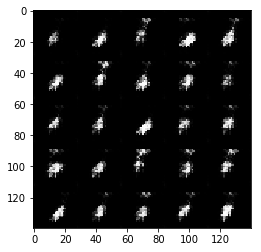

Epoch 1/2... Discriminator Loss: 0.8861... Generator Loss: 1.3842
Epoch 1/2... Discriminator Loss: 0.8675... Generator Loss: 1.8651
Epoch 1/2... Discriminator Loss: 0.7863... Generator Loss: 1.4733
Epoch 1/2... Discriminator Loss: 1.3384... Generator Loss: 0.7288
Epoch 1/2... Discriminator Loss: 0.9858... Generator Loss: 1.1684


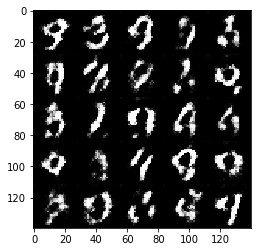

Epoch 1/2... Discriminator Loss: 1.0387... Generator Loss: 1.4303
Epoch 1/2... Discriminator Loss: 1.0115... Generator Loss: 1.3881
Epoch 1/2... Discriminator Loss: 1.2589... Generator Loss: 0.6959
Epoch 1/2... Discriminator Loss: 1.1320... Generator Loss: 1.1487
Epoch 1/2... Discriminator Loss: 1.1571... Generator Loss: 0.7975


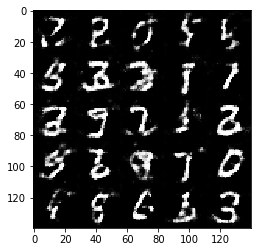

Epoch 1/2... Discriminator Loss: 1.1792... Generator Loss: 0.7314
Epoch 1/2... Discriminator Loss: 1.4061... Generator Loss: 0.9563
Epoch 1/2... Discriminator Loss: 1.1922... Generator Loss: 0.7627
Epoch 1/2... Discriminator Loss: 1.0890... Generator Loss: 0.9939
Epoch 1/2... Discriminator Loss: 1.1565... Generator Loss: 1.1581


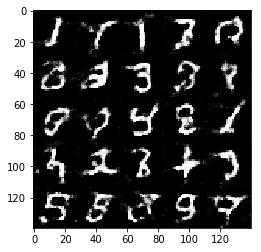

Epoch 1/2... Discriminator Loss: 1.1348... Generator Loss: 1.1215
Epoch 1/2... Discriminator Loss: 1.1413... Generator Loss: 1.0553
Epoch 1/2... Discriminator Loss: 1.0641... Generator Loss: 1.0011
Epoch 1/2... Discriminator Loss: 1.1274... Generator Loss: 0.7926
Epoch 1/2... Discriminator Loss: 1.0204... Generator Loss: 1.4969


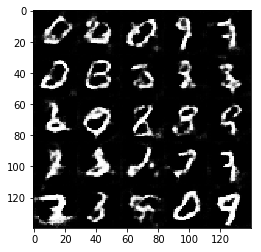

Epoch 1/2... Discriminator Loss: 0.9471... Generator Loss: 1.2766
Epoch 1/2... Discriminator Loss: 1.2167... Generator Loss: 0.7598
Epoch 1/2... Discriminator Loss: 1.0393... Generator Loss: 0.8703
Epoch 1/2... Discriminator Loss: 1.0944... Generator Loss: 0.9448
Epoch 1/2... Discriminator Loss: 1.1366... Generator Loss: 0.8140


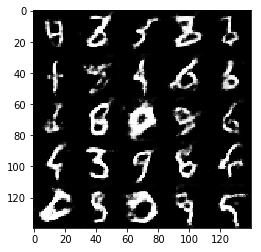

Epoch 1/2... Discriminator Loss: 1.1329... Generator Loss: 0.7125
Epoch 1/2... Discriminator Loss: 1.0265... Generator Loss: 0.8646
Epoch 1/2... Discriminator Loss: 1.1882... Generator Loss: 2.1912
Epoch 1/2... Discriminator Loss: 1.4346... Generator Loss: 0.4810
Epoch 1/2... Discriminator Loss: 1.2117... Generator Loss: 0.6358


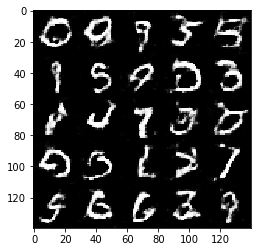

Epoch 1/2... Discriminator Loss: 1.0473... Generator Loss: 0.8889
Epoch 1/2... Discriminator Loss: 0.9885... Generator Loss: 1.2549
Epoch 1/2... Discriminator Loss: 0.9644... Generator Loss: 1.6632
Epoch 1/2... Discriminator Loss: 1.1816... Generator Loss: 1.6721
Epoch 1/2... Discriminator Loss: 0.8724... Generator Loss: 1.4964


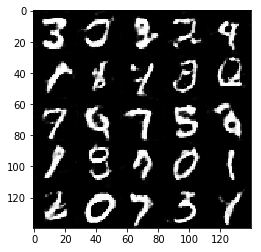

Epoch 1/2... Discriminator Loss: 1.7944... Generator Loss: 2.5426
Epoch 1/2... Discriminator Loss: 1.0162... Generator Loss: 1.0184
Epoch 1/2... Discriminator Loss: 1.0153... Generator Loss: 1.0314
Epoch 1/2... Discriminator Loss: 1.3316... Generator Loss: 2.4516
Epoch 1/2... Discriminator Loss: 0.9930... Generator Loss: 0.9743


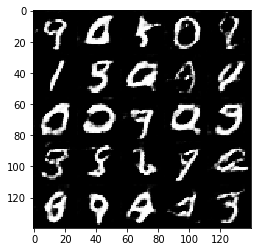

Epoch 1/2... Discriminator Loss: 1.1069... Generator Loss: 0.7770
Epoch 2/2... Discriminator Loss: 1.4201... Generator Loss: 0.4744
Epoch 2/2... Discriminator Loss: 1.0663... Generator Loss: 1.1309
Epoch 2/2... Discriminator Loss: 1.0487... Generator Loss: 0.8974
Epoch 2/2... Discriminator Loss: 1.0976... Generator Loss: 0.7151


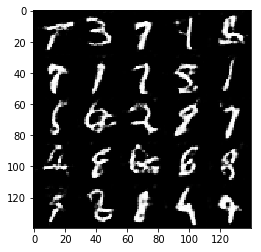

Epoch 2/2... Discriminator Loss: 0.9475... Generator Loss: 1.3001
Epoch 2/2... Discriminator Loss: 1.2410... Generator Loss: 0.6009
Epoch 2/2... Discriminator Loss: 1.3547... Generator Loss: 0.5105
Epoch 2/2... Discriminator Loss: 1.2042... Generator Loss: 0.6958
Epoch 2/2... Discriminator Loss: 0.8659... Generator Loss: 1.3200


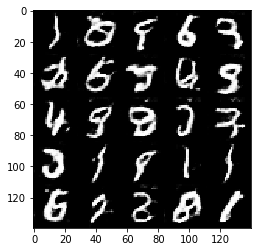

Epoch 2/2... Discriminator Loss: 1.0971... Generator Loss: 0.7229
Epoch 2/2... Discriminator Loss: 0.8619... Generator Loss: 1.5685
Epoch 2/2... Discriminator Loss: 0.7230... Generator Loss: 1.8956
Epoch 2/2... Discriminator Loss: 1.1956... Generator Loss: 0.6509
Epoch 2/2... Discriminator Loss: 0.8887... Generator Loss: 1.5366


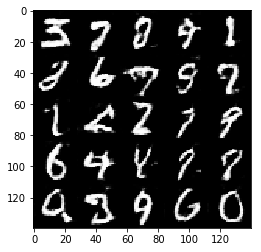

Epoch 2/2... Discriminator Loss: 0.8849... Generator Loss: 1.1426
Epoch 2/2... Discriminator Loss: 0.8929... Generator Loss: 1.3052
Epoch 2/2... Discriminator Loss: 1.2392... Generator Loss: 0.6261
Epoch 2/2... Discriminator Loss: 1.3096... Generator Loss: 0.5590
Epoch 2/2... Discriminator Loss: 1.1112... Generator Loss: 0.7329


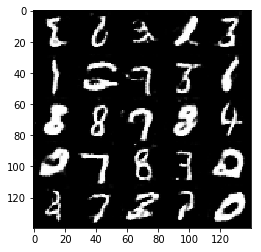

Epoch 2/2... Discriminator Loss: 1.2506... Generator Loss: 0.6057
Epoch 2/2... Discriminator Loss: 1.0640... Generator Loss: 0.7787
Epoch 2/2... Discriminator Loss: 0.8355... Generator Loss: 1.4681
Epoch 2/2... Discriminator Loss: 0.9989... Generator Loss: 0.9366
Epoch 2/2... Discriminator Loss: 1.2991... Generator Loss: 2.0636


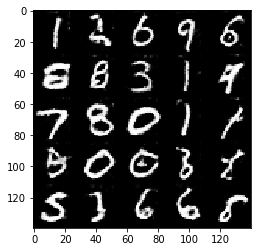

Epoch 2/2... Discriminator Loss: 0.9211... Generator Loss: 1.0558
Epoch 2/2... Discriminator Loss: 1.2111... Generator Loss: 0.6731
Epoch 2/2... Discriminator Loss: 0.8548... Generator Loss: 1.2729
Epoch 2/2... Discriminator Loss: 1.0328... Generator Loss: 0.8624
Epoch 2/2... Discriminator Loss: 1.1275... Generator Loss: 0.7352


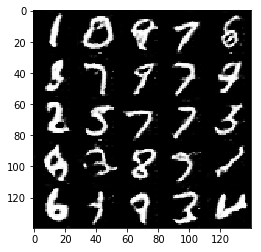

Epoch 2/2... Discriminator Loss: 0.7643... Generator Loss: 1.3162
Epoch 2/2... Discriminator Loss: 0.8774... Generator Loss: 1.1655
Epoch 2/2... Discriminator Loss: 0.9800... Generator Loss: 0.9764
Epoch 2/2... Discriminator Loss: 1.3172... Generator Loss: 0.5935
Epoch 2/2... Discriminator Loss: 1.1476... Generator Loss: 0.6840


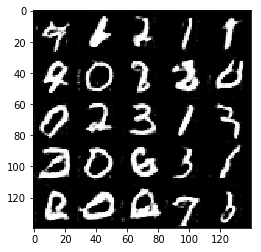

Epoch 2/2... Discriminator Loss: 0.8154... Generator Loss: 1.3195
Epoch 2/2... Discriminator Loss: 1.2973... Generator Loss: 0.5947
Epoch 2/2... Discriminator Loss: 0.9741... Generator Loss: 2.5016
Epoch 2/2... Discriminator Loss: 1.1048... Generator Loss: 0.7890
Epoch 2/2... Discriminator Loss: 0.8575... Generator Loss: 1.3014


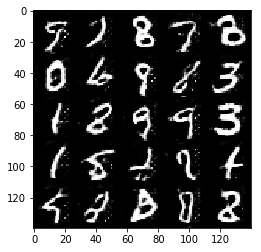

Epoch 2/2... Discriminator Loss: 0.7303... Generator Loss: 1.7291
Epoch 2/2... Discriminator Loss: 1.0174... Generator Loss: 0.8508
Epoch 2/2... Discriminator Loss: 0.9891... Generator Loss: 0.9028
Epoch 2/2... Discriminator Loss: 0.8013... Generator Loss: 1.4203
Epoch 2/2... Discriminator Loss: 0.8362... Generator Loss: 1.2267


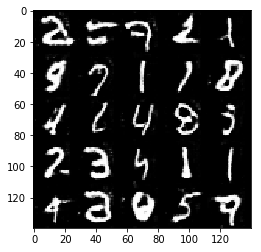

Epoch 2/2... Discriminator Loss: 0.8996... Generator Loss: 1.3443
Epoch 2/2... Discriminator Loss: 1.1519... Generator Loss: 0.7088
Epoch 2/2... Discriminator Loss: 1.3412... Generator Loss: 0.5978


In [33]:
batch_size = 32
z_dim = 100
learning_rate = 2e-4
beta1 = 0.5

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.4514... Generator Loss: 8.5254
Epoch 1/1... Discriminator Loss: 0.6426... Generator Loss: 3.4717
Epoch 1/1... Discriminator Loss: 0.4757... Generator Loss: 2.4195
Epoch 1/1... Discriminator Loss: 0.4145... Generator Loss: 6.2550
Epoch 1/1... Discriminator Loss: 0.3702... Generator Loss: 3.7810


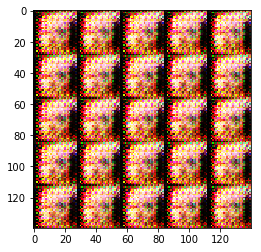

Epoch 1/1... Discriminator Loss: 0.4056... Generator Loss: 4.0933
Epoch 1/1... Discriminator Loss: 0.5401... Generator Loss: 9.4082
Epoch 1/1... Discriminator Loss: 0.3659... Generator Loss: 4.3182
Epoch 1/1... Discriminator Loss: 0.3691... Generator Loss: 4.2272
Epoch 1/1... Discriminator Loss: 0.4931... Generator Loss: 2.2845


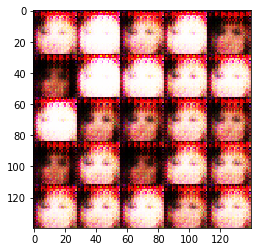

Epoch 1/1... Discriminator Loss: 0.5316... Generator Loss: 2.9277
Epoch 1/1... Discriminator Loss: 0.6667... Generator Loss: 3.0034
Epoch 1/1... Discriminator Loss: 1.2334... Generator Loss: 0.6739
Epoch 1/1... Discriminator Loss: 0.6201... Generator Loss: 2.0676
Epoch 1/1... Discriminator Loss: 1.0847... Generator Loss: 0.9130


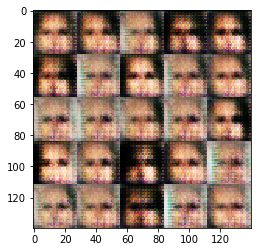

Epoch 1/1... Discriminator Loss: 0.6349... Generator Loss: 2.1109
Epoch 1/1... Discriminator Loss: 0.6529... Generator Loss: 1.7975
Epoch 1/1... Discriminator Loss: 0.9272... Generator Loss: 1.3426
Epoch 1/1... Discriminator Loss: 1.4151... Generator Loss: 0.5312
Epoch 1/1... Discriminator Loss: 0.6747... Generator Loss: 2.2834


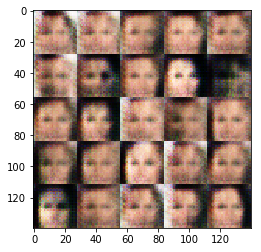

Epoch 1/1... Discriminator Loss: 0.8378... Generator Loss: 1.4462
Epoch 1/1... Discriminator Loss: 1.0126... Generator Loss: 1.6187
Epoch 1/1... Discriminator Loss: 0.7611... Generator Loss: 1.6009
Epoch 1/1... Discriminator Loss: 1.2314... Generator Loss: 0.9835
Epoch 1/1... Discriminator Loss: 1.7369... Generator Loss: 0.4501


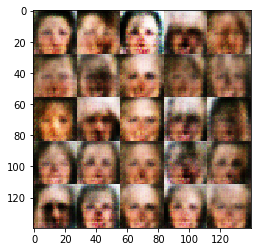

Epoch 1/1... Discriminator Loss: 1.1175... Generator Loss: 1.1090
Epoch 1/1... Discriminator Loss: 0.6482... Generator Loss: 1.8692
Epoch 1/1... Discriminator Loss: 1.0423... Generator Loss: 1.9834
Epoch 1/1... Discriminator Loss: 1.5635... Generator Loss: 1.4911
Epoch 1/1... Discriminator Loss: 1.2124... Generator Loss: 0.9490


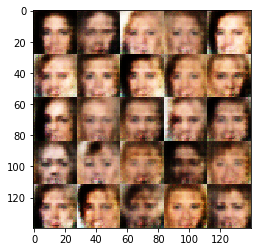

Epoch 1/1... Discriminator Loss: 0.9210... Generator Loss: 1.1342
Epoch 1/1... Discriminator Loss: 0.8907... Generator Loss: 1.2520
Epoch 1/1... Discriminator Loss: 0.9492... Generator Loss: 1.2803
Epoch 1/1... Discriminator Loss: 1.2632... Generator Loss: 1.0262
Epoch 1/1... Discriminator Loss: 0.7424... Generator Loss: 1.6523


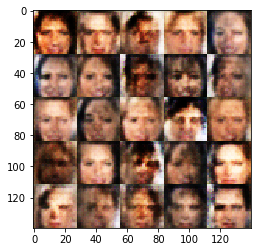

Epoch 1/1... Discriminator Loss: 1.0052... Generator Loss: 1.3597
Epoch 1/1... Discriminator Loss: 0.9459... Generator Loss: 1.6653
Epoch 1/1... Discriminator Loss: 1.1338... Generator Loss: 1.4967
Epoch 1/1... Discriminator Loss: 0.7730... Generator Loss: 1.3592
Epoch 1/1... Discriminator Loss: 1.0049... Generator Loss: 1.7169


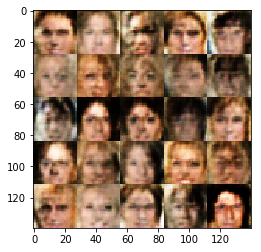

Epoch 1/1... Discriminator Loss: 1.2763... Generator Loss: 3.3826
Epoch 1/1... Discriminator Loss: 0.8724... Generator Loss: 1.1862
Epoch 1/1... Discriminator Loss: 1.0688... Generator Loss: 1.0008
Epoch 1/1... Discriminator Loss: 1.4041... Generator Loss: 0.5243
Epoch 1/1... Discriminator Loss: 1.0266... Generator Loss: 1.0519


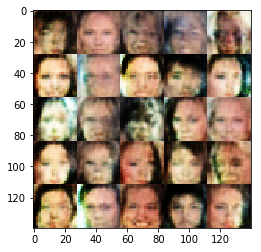

Epoch 1/1... Discriminator Loss: 1.0697... Generator Loss: 0.9403
Epoch 1/1... Discriminator Loss: 1.2257... Generator Loss: 0.6827
Epoch 1/1... Discriminator Loss: 1.0070... Generator Loss: 1.4530
Epoch 1/1... Discriminator Loss: 1.3979... Generator Loss: 4.8566
Epoch 1/1... Discriminator Loss: 0.6449... Generator Loss: 1.9675


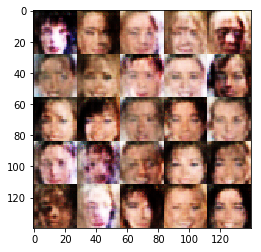

Epoch 1/1... Discriminator Loss: 1.2189... Generator Loss: 0.8069
Epoch 1/1... Discriminator Loss: 0.6037... Generator Loss: 2.2883
Epoch 1/1... Discriminator Loss: 0.9111... Generator Loss: 1.1735
Epoch 1/1... Discriminator Loss: 1.4014... Generator Loss: 3.6068
Epoch 1/1... Discriminator Loss: 1.2408... Generator Loss: 0.8534


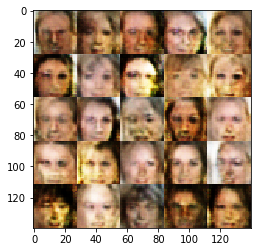

Epoch 1/1... Discriminator Loss: 1.0049... Generator Loss: 1.1472
Epoch 1/1... Discriminator Loss: 1.2300... Generator Loss: 0.7504
Epoch 1/1... Discriminator Loss: 1.1114... Generator Loss: 0.8140
Epoch 1/1... Discriminator Loss: 1.3503... Generator Loss: 0.5045
Epoch 1/1... Discriminator Loss: 1.4964... Generator Loss: 0.4702


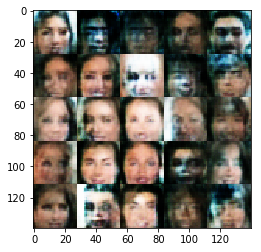

Epoch 1/1... Discriminator Loss: 1.5556... Generator Loss: 1.0595
Epoch 1/1... Discriminator Loss: 1.0103... Generator Loss: 0.9682
Epoch 1/1... Discriminator Loss: 1.4174... Generator Loss: 0.5001
Epoch 1/1... Discriminator Loss: 0.8396... Generator Loss: 1.5884
Epoch 1/1... Discriminator Loss: 0.9845... Generator Loss: 1.8724


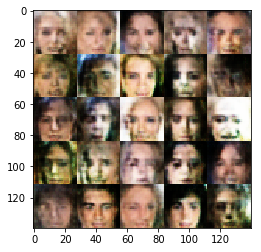

Epoch 1/1... Discriminator Loss: 1.7833... Generator Loss: 0.3475
Epoch 1/1... Discriminator Loss: 1.0773... Generator Loss: 0.8820
Epoch 1/1... Discriminator Loss: 1.1784... Generator Loss: 2.5677
Epoch 1/1... Discriminator Loss: 1.1441... Generator Loss: 0.9901
Epoch 1/1... Discriminator Loss: 0.9417... Generator Loss: 1.3238


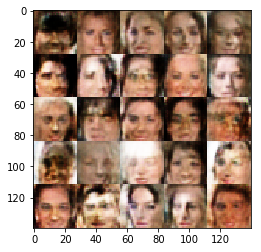

Epoch 1/1... Discriminator Loss: 1.2228... Generator Loss: 1.1797
Epoch 1/1... Discriminator Loss: 1.1499... Generator Loss: 1.0931
Epoch 1/1... Discriminator Loss: 1.0186... Generator Loss: 1.2058
Epoch 1/1... Discriminator Loss: 0.9048... Generator Loss: 1.2697
Epoch 1/1... Discriminator Loss: 1.1442... Generator Loss: 0.7721


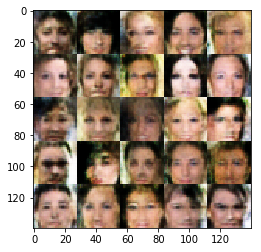

Epoch 1/1... Discriminator Loss: 0.9022... Generator Loss: 1.3647
Epoch 1/1... Discriminator Loss: 0.7330... Generator Loss: 1.7660
Epoch 1/1... Discriminator Loss: 1.0700... Generator Loss: 0.8244
Epoch 1/1... Discriminator Loss: 1.1185... Generator Loss: 1.3866
Epoch 1/1... Discriminator Loss: 0.9806... Generator Loss: 2.5703


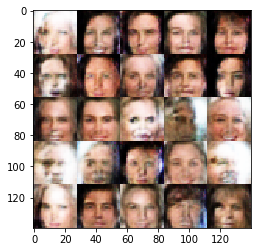

Epoch 1/1... Discriminator Loss: 1.0379... Generator Loss: 1.5076
Epoch 1/1... Discriminator Loss: 1.1805... Generator Loss: 0.7941
Epoch 1/1... Discriminator Loss: 1.0224... Generator Loss: 1.0980
Epoch 1/1... Discriminator Loss: 0.8716... Generator Loss: 1.4261
Epoch 1/1... Discriminator Loss: 0.9962... Generator Loss: 1.2159


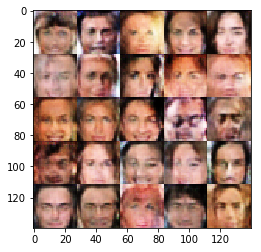

Epoch 1/1... Discriminator Loss: 1.0357... Generator Loss: 1.0110
Epoch 1/1... Discriminator Loss: 0.9785... Generator Loss: 1.1784
Epoch 1/1... Discriminator Loss: 1.0090... Generator Loss: 1.2271
Epoch 1/1... Discriminator Loss: 1.2568... Generator Loss: 0.8137
Epoch 1/1... Discriminator Loss: 0.8385... Generator Loss: 1.2461


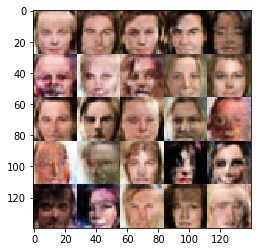

Epoch 1/1... Discriminator Loss: 1.0901... Generator Loss: 0.8334
Epoch 1/1... Discriminator Loss: 1.0661... Generator Loss: 0.8845
Epoch 1/1... Discriminator Loss: 0.9615... Generator Loss: 1.1300
Epoch 1/1... Discriminator Loss: 1.1212... Generator Loss: 0.8168
Epoch 1/1... Discriminator Loss: 1.0648... Generator Loss: 1.0274


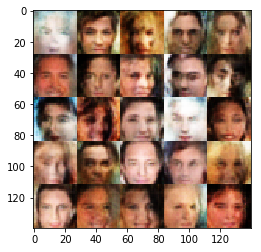

Epoch 1/1... Discriminator Loss: 1.0415... Generator Loss: 1.6250
Epoch 1/1... Discriminator Loss: 1.0929... Generator Loss: 0.9643
Epoch 1/1... Discriminator Loss: 1.1820... Generator Loss: 0.7427
Epoch 1/1... Discriminator Loss: 1.1390... Generator Loss: 1.0525
Epoch 1/1... Discriminator Loss: 1.2729... Generator Loss: 0.7708


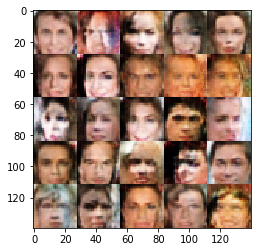

Epoch 1/1... Discriminator Loss: 1.1465... Generator Loss: 1.0733
Epoch 1/1... Discriminator Loss: 0.8041... Generator Loss: 1.6849
Epoch 1/1... Discriminator Loss: 1.2211... Generator Loss: 0.6908
Epoch 1/1... Discriminator Loss: 1.0450... Generator Loss: 0.8221
Epoch 1/1... Discriminator Loss: 0.9220... Generator Loss: 1.2412


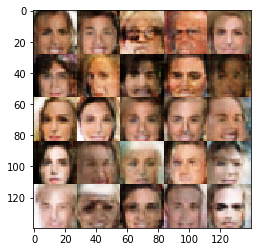

Epoch 1/1... Discriminator Loss: 0.9042... Generator Loss: 1.2356
Epoch 1/1... Discriminator Loss: 0.6697... Generator Loss: 1.8223
Epoch 1/1... Discriminator Loss: 1.1731... Generator Loss: 0.9281
Epoch 1/1... Discriminator Loss: 1.4609... Generator Loss: 0.4953
Epoch 1/1... Discriminator Loss: 1.0838... Generator Loss: 1.0469


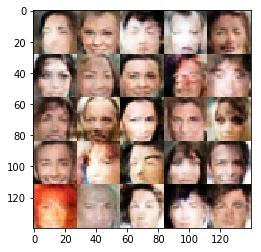

Epoch 1/1... Discriminator Loss: 1.2633... Generator Loss: 0.9022
Epoch 1/1... Discriminator Loss: 0.9084... Generator Loss: 1.3959
Epoch 1/1... Discriminator Loss: 1.2010... Generator Loss: 0.7187
Epoch 1/1... Discriminator Loss: 1.0152... Generator Loss: 1.0513
Epoch 1/1... Discriminator Loss: 1.1612... Generator Loss: 0.8278


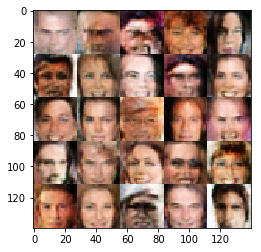

Epoch 1/1... Discriminator Loss: 0.8158... Generator Loss: 1.4388
Epoch 1/1... Discriminator Loss: 1.1460... Generator Loss: 1.1901
Epoch 1/1... Discriminator Loss: 1.1165... Generator Loss: 0.9879
Epoch 1/1... Discriminator Loss: 1.6238... Generator Loss: 0.3635
Epoch 1/1... Discriminator Loss: 1.2141... Generator Loss: 0.8240


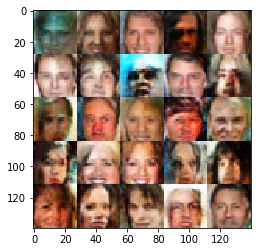

Epoch 1/1... Discriminator Loss: 1.3043... Generator Loss: 0.5923
Epoch 1/1... Discriminator Loss: 1.2036... Generator Loss: 1.0430
Epoch 1/1... Discriminator Loss: 1.1224... Generator Loss: 0.8146
Epoch 1/1... Discriminator Loss: 1.3888... Generator Loss: 0.5624
Epoch 1/1... Discriminator Loss: 1.0286... Generator Loss: 0.8930


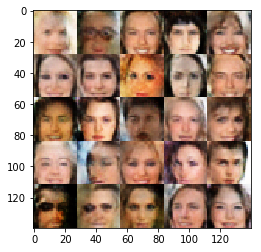

Epoch 1/1... Discriminator Loss: 0.8002... Generator Loss: 1.4386
Epoch 1/1... Discriminator Loss: 1.0224... Generator Loss: 1.5382
Epoch 1/1... Discriminator Loss: 1.1295... Generator Loss: 1.0234
Epoch 1/1... Discriminator Loss: 1.2059... Generator Loss: 0.7026
Epoch 1/1... Discriminator Loss: 0.7085... Generator Loss: 1.9553


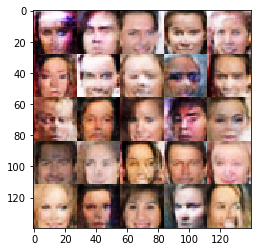

Epoch 1/1... Discriminator Loss: 1.2936... Generator Loss: 0.8550
Epoch 1/1... Discriminator Loss: 1.2497... Generator Loss: 0.6212
Epoch 1/1... Discriminator Loss: 0.9824... Generator Loss: 1.0600
Epoch 1/1... Discriminator Loss: 1.1667... Generator Loss: 0.8705
Epoch 1/1... Discriminator Loss: 1.1372... Generator Loss: 1.5791


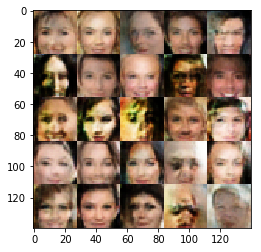

Epoch 1/1... Discriminator Loss: 1.1422... Generator Loss: 0.7674
Epoch 1/1... Discriminator Loss: 1.2818... Generator Loss: 0.7411
Epoch 1/1... Discriminator Loss: 1.2654... Generator Loss: 1.6029
Epoch 1/1... Discriminator Loss: 1.3455... Generator Loss: 0.5854
Epoch 1/1... Discriminator Loss: 1.2804... Generator Loss: 0.6704


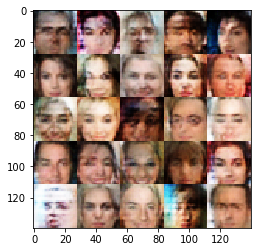

Epoch 1/1... Discriminator Loss: 1.0999... Generator Loss: 1.0198
Epoch 1/1... Discriminator Loss: 1.2833... Generator Loss: 0.6580
Epoch 1/1... Discriminator Loss: 1.1844... Generator Loss: 0.9047
Epoch 1/1... Discriminator Loss: 1.0017... Generator Loss: 1.0389
Epoch 1/1... Discriminator Loss: 1.4110... Generator Loss: 0.5312


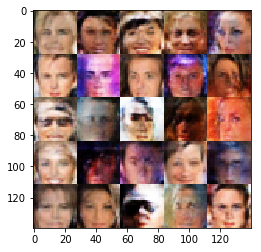

Epoch 1/1... Discriminator Loss: 1.1304... Generator Loss: 0.9112
Epoch 1/1... Discriminator Loss: 1.2253... Generator Loss: 0.8319
Epoch 1/1... Discriminator Loss: 1.2533... Generator Loss: 0.6712
Epoch 1/1... Discriminator Loss: 1.0427... Generator Loss: 0.8977
Epoch 1/1... Discriminator Loss: 1.0131... Generator Loss: 1.9022


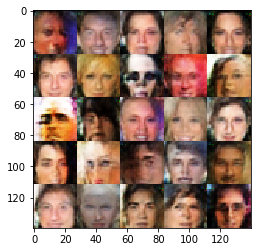

Epoch 1/1... Discriminator Loss: 1.0977... Generator Loss: 1.3042
Epoch 1/1... Discriminator Loss: 1.3118... Generator Loss: 0.5808
Epoch 1/1... Discriminator Loss: 1.0649... Generator Loss: 0.7859
Epoch 1/1... Discriminator Loss: 1.4398... Generator Loss: 0.4903
Epoch 1/1... Discriminator Loss: 1.2116... Generator Loss: 1.3036


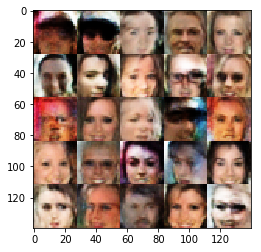

Epoch 1/1... Discriminator Loss: 0.8955... Generator Loss: 1.3542
Epoch 1/1... Discriminator Loss: 0.9692... Generator Loss: 1.0945
Epoch 1/1... Discriminator Loss: 1.0953... Generator Loss: 0.9477


In [34]:
batch_size = 32
z_dim = 100
learning_rate = 2e-4
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.